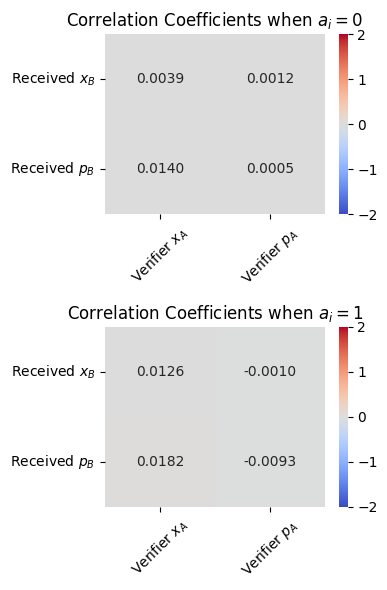

In [1]:
import strawberryfields as sf
from strawberryfields.ops import MeasureHD, S2gate, Rgate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

num_runs = 100000
r = 1.0
rotation_angle = np.pi / 2

a_i = np.random.randint(0, 2, size=num_runs)

verifier_x_V1 = []
verifier_p_V1 = []
received_x_P = []
received_p_P = []

for i in range(num_runs):
    prog_V = sf.Program(2)

    with prog_V.context as q_V:
        S2gate(r) | (q_V[0], q_V[1])
        MeasureHD | q_V[0]

    eng_V = sf.Engine("gaussian")
    result_V = eng_V.run(prog_V)

    verifier_result_V1 = result_V.samples[0][0]

    verifier_x_V1_val = float(np.real(verifier_result_V1).item())
    verifier_p_V1_val = float(np.imag(verifier_result_V1).item())
    verifier_x_V1.append(verifier_x_V1_val)
    verifier_p_V1.append(verifier_p_V1_val)

    prog_MP = sf.Program(2)

    with prog_MP.context as q_MP:
        S2gate(r) | (q_MP[0], q_MP[1])

        if a_i[i] == 1:
            Rgate(rotation_angle) | q_MP[1]

        MeasureHD | q_MP[1]

    eng_MP = sf.Engine("gaussian")
    result_MP = eng_MP.run(prog_MP)

    prover_result = result_MP.samples[0]

    received_x_P_val = float(np.real(prover_result).item())
    received_p_P_val = float(np.imag(prover_result).item())
    received_x_P.append(received_x_P_val)
    received_p_P.append(received_p_P_val)

verifier_x_V1 = np.array(verifier_x_V1)
verifier_p_V1 = np.array(verifier_p_V1)
received_x_P = np.array(received_x_P)
received_p_P = np.array(received_p_P)

valid_response = ~np.isnan(received_x_P) & ~np.isnan(received_p_P)

indices_a0 = np.where((a_i == 0) & valid_response)[0]
indices_a1 = np.where((a_i == 1) & valid_response)[0]

def calculate_covariance(X, Y):
    return np.mean(X * Y) - np.mean(X) * np.mean(Y)

cov_x_A_a0_p_B = 2 * calculate_covariance(verifier_x_V1[indices_a0], received_p_P[indices_a0])
cov_p_A_a0_x_B = 2 * calculate_covariance(verifier_p_V1[indices_a0], received_x_P[indices_a0])
cov_x_A_a0_x_B = 2 * calculate_covariance(verifier_x_V1[indices_a0], received_x_P[indices_a0])
cov_p_A_a0_p_B = 2 * calculate_covariance(verifier_p_V1[indices_a0], received_p_P[indices_a0])

cov_x_A_a1_x_B = 2 * calculate_covariance(verifier_x_V1[indices_a1], received_x_P[indices_a1])
cov_p_A_a1_p_B = 2 * calculate_covariance(verifier_p_V1[indices_a1], received_p_P[indices_a1])
cov_x_A_a1_p_B = 2 * calculate_covariance(verifier_x_V1[indices_a1], received_p_P[indices_a1])
cov_p_A_a1_x_B = 2 * calculate_covariance(verifier_p_V1[indices_a1], received_x_P[indices_a1])

cov_a0 = {
    "Verifier $x_A$": {
        "Received $x_B$": cov_x_A_a0_x_B,
        "Received $p_B$": cov_x_A_a0_p_B
    },
    "Verifier $p_A$": {
        "Received $x_B$": cov_p_A_a0_x_B,
        "Received $p_B$": cov_p_A_a0_p_B
    }
}

cov_a1 = {
    "Verifier $x_A$": {
        "Received $x_B$": cov_x_A_a1_x_B,
        "Received $p_B$": cov_x_A_a1_p_B
    },
    "Verifier $p_A$": {
        "Received $x_B$": cov_p_A_a1_x_B,
        "Received $p_B$": cov_p_A_a1_p_B
    }
}

df_a0 = pd.DataFrame(cov_a0)
df_a1 = pd.DataFrame(cov_a1)

max_cov = max(df_a0.abs().values.max(), df_a1.abs().values.max())

plt.figure(figsize=(4, 6))

plt.subplot(2, 1, 1)
sns.heatmap(df_a0, annot=True, fmt=".4f", cmap="coolwarm", vmin=-2, vmax=2)
plt.title("Correlation Coefficients when $a_i = 0$")
plt.yticks(rotation=0)
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.heatmap(df_a1, annot=True, fmt=".4f", cmap="coolwarm", vmin=-2, vmax=2)
plt.title("Correlation Coefficients when $a_i = 1$")
plt.yticks(rotation=0)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
